# Some experiments on what I am capable of

First, we have to load our dataset in.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Normally I would do some dataset exploration, but since I explored this in the past, I don't find it necessary and would just like to focus exactly on what I am capable of. Let's do some basic visualizations, and then we could do a test/train/val split. We're going to be attempting to predict the sepal width.

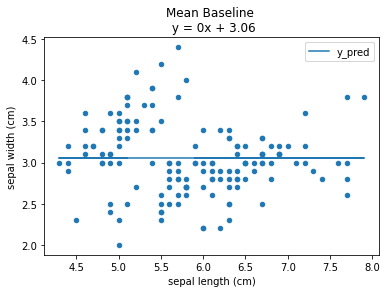

In [ ]:
ax = df.plot.scatter('sepal length (cm)', 'sepal width (cm)')
mean = df['sepal width (cm)'].mean()
df['y_pred'] = mean
title = f'Mean Baseline \n y = 0x + {mean:.2f}'
df.plot('sepal length (cm)', 'y_pred', ax=ax, title=title);

In [ ]:
import plotly.express as px
fig = px.scatter(df,x = 'sepal length (cm)', y = 'sepal width (cm)', trendline='ols')
fig.show()

In [ ]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_pred
count,150.000000,150.000000,150.000000,150.000000,1.500000e+02
mean,5.843333,3.057333,3.758000,1.199333,3.057333e+00
std,0.828066,0.435866,1.765298,0.762238,1.113942e-14
min,4.300000,2.000000,1.000000,0.100000,3.057333e+00
25%,5.100000,2.800000,1.600000,0.300000,3.057333e+00
50%,5.800000,3.000000,4.350000,1.300000,3.057333e+00
75%,6.400000,3.300000,5.100000,1.800000,3.057333e+00
max,7.900000,4.400000,6.900000,2.500000,3.057333e+00


In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df, train_size=0.8, test_size=0.2)
#The reason why we want to a large portion of the split to go into train
#is so that we can still maintain a reasonable amount by the time we create our validation split.
train,val = train_test_split(train,train_size=0.8,test_size=0.2)
target = 'sepal width (cm)'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
#making sure that our data is still relatively the same and has split properly.
train.describe()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_pred
count,96.000000,96.000000,96.000000,96.000000,9.600000e+01
mean,5.846875,3.062500,3.748958,1.173958,3.057333e+00
std,0.867295,0.462317,1.807528,0.763406,2.232102e-15
min,4.300000,2.000000,1.000000,0.100000,3.057333e+00
25%,5.100000,2.800000,1.500000,0.300000,3.057333e+00
50%,5.800000,3.000000,4.350000,1.300000,3.057333e+00
75%,6.400000,3.400000,5.100000,1.800000,3.057333e+00
max,7.900000,4.400000,6.900000,2.500000,3.057333e+00


Let's experiment with different pipelines and see how accurately we could predict our model. We'll start off with Random Forest Regression. Random Forest is a type of decision tree where it'll offer two different scenarios, go with the one that the results match, offer two more scenarios, etc. until it finally reaches the end. For example:

Our number is 5.

Is our number bigger than 3 or less than or equal to 3?
If bigger than 3, is it bigger than 6 or less than or equal to 6?
Is our number bigger than 4 or less than 4?

In this specific scenario, random forest wouldn't be our best approach, but it's better in cases that are more binary and offer a limited number of end results.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pipeline=make_pipeline(
     RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42)
)
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5684209333348098


Let's try XGBRegression. XGBoost is a powerful approach to most supervised machine learning issues, combining both efficiency and speed. It essentially takes the bad and inaccurate predictions and sums it up with the more accurate predictions, canceling out the ones that are inaccurate.

In [ ]:
from xgboost import XGBRegressor
pipeline = make_pipeline(
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
mse=mean_squared_error(y_val,y_pred)
r2 = r2_score(y_val, y_pred)
rmse=np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
print('Test MSE:',mse)
print('Test R^2:',r2)
print('Test RMSE:',rmse)

[21:00:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test MSE: 0.04659321739802191
Test R^2: 0.6357039063219679
Test RMSE: 0.21585462097907915


XGBoost definitely seems like our best one by far. Make note of this as we will return to it later on.

We'll, however, move onto a randomized search method. In this one, it is supported by a high-powered API that, instead of being based upon a model, is based upon our hyper-parameters. The accuracy of its results are mostly determined by the parameters you feed into it; however, sometimes, it struggles with predicting data that is more simplified, as you'll see in our results.

In [ ]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    XGBRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)
search.fit(X_train, y_train)
pipeline = search.best_estimator_
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
mse=mean_squared_error(y_val,y_pred)
r2 = r2_score(y_val, y_pred)
rmse=np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
print('Test MSE:',mse)
print('Test R^2:',r2)
print('Test RMSE:',rmse)
print('Test MAE:', mae)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1710s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.6s finished


[21:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test MSE: 0.07879363591826784
Test R^2: 0.38394008023724346
Test RMSE: 0.28070204117225056
Test MAE: 0.22998559474945068


While the score from our Random Search seems impressive on its own, it pales in comparison to our XGBoost. Finally, we'll conclude with linear regression. While I expect the score to be poor, I'm only going through with it to demonstrate that I am capable of several different approaches.

In [ ]:
from sklearn.linear_model import LinearRegression
pipelineLinear = make_pipeline(
    LinearRegression()
)
pipelineLinear.fit(X_train, y_train)
print('Validation Accuracy', pipelineLinear.score(X_val, y_val))

Validation Accuracy 0.43015952384086864


We finally got to the point where we have a model that is both very accurate and is within reasonable parameters. We'll go over some visualizations just for fun and then we'll finish with two visualizations that encapsulate our findings.

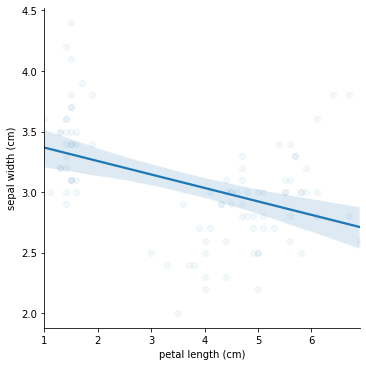

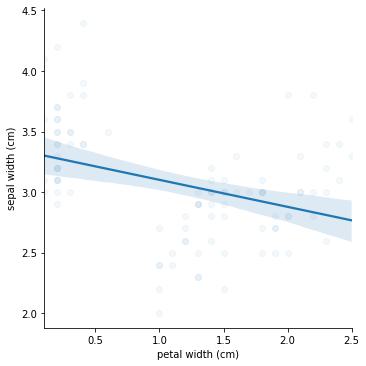

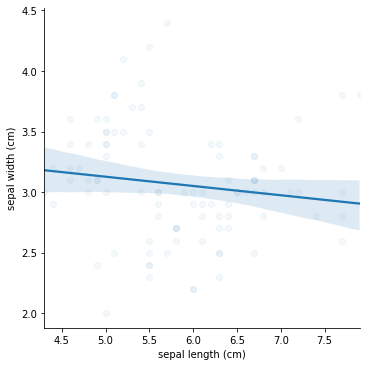

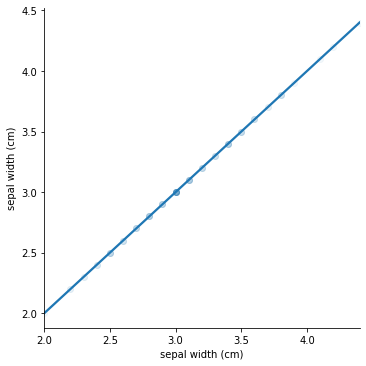

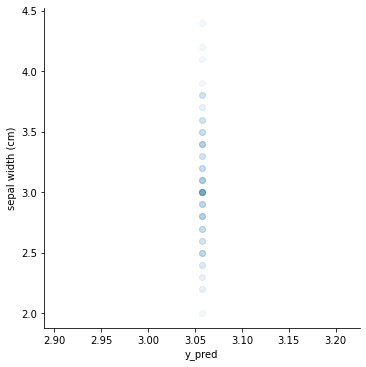

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='sepal width (cm)', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

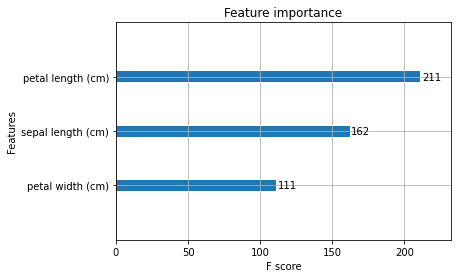

In [ ]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_jobs=-1,objective='reg:squarederror')
model_xgb.fit(X_train, y_train)
axsub = xgb.plot_importance(model_xgb)

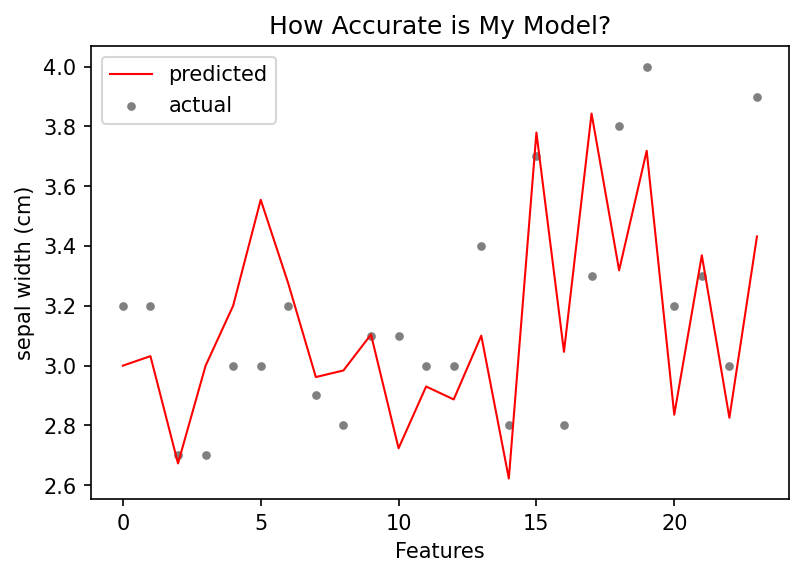

In [ ]:
y_pred = pipeline.predict(X_val)
X_ax = range(len(y_val))
plt.figure(dpi=150)
plt.scatter (X_ax, y_val, s=10, color= 'grey', label= 'actual')
plt.plot(X_ax, y_pred, lw=1.0, color= 'red', label= 'predicted')
plt.title('How Accurate is My Model?')
plt.xlabel('Features')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.show()

In the end, we left with a very accurate model without any concerns of overfitting. In most cases, I would normally spend a large amount of time cleaning the data, encoding it, making sure there is no mixed data types, etc. This project was simply to update my portfolio to show that I am still active in my field. Besides predictive modeling, I am also capable of several other tasks in relation to data science. Statistics, data analysis, natural language processing, data engineering, MySQL, and much more.

If you're seeing this, I hope to hear from you soon.